In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange # progress bars

import torch
import torch.nn as nn
import torch.nn.functional as F

from TTT_env import TTT
from neural_nets import ValueNet, PolicyNet, Training
from mcts import MCTS, Node
from self_play import Self_Play
import pickle

In [3]:
parameter_path = "./dnn_checkpoints2/"
iterations = 5 # number of `play -> train` loops
games = 1000 # games per self-play session
depth = 250 # search depth for monte-carlo tree search
temperature = 1 # temperature determining action-selection based on MCTS visit count
lr_p = 0.005 # learning rate for policy net
lr_v = 0.001 # learning rate for value net
batchsize_p = 64
batchsize_v = 64
epochs_p = 4
epochs_v = 4

for v in range(iterations):
    
    # start with self-play
    print("Self-Play: Iter {} out of {}".format(v+1, iterations))

    if v > 22:
        fn = parameter_path + 'game_data_v{}.data'.format(v)
        with open(fn, "rb") as f:
            state_log, mcts_log, win_log = pickle.load(f)
    else:
        engine = Self_Play(games=games, depth=depth, temperature=temperature, parameter_path = parameter_path)
        state_log, mcts_log, win_log = engine.play(version=v)
    
    
    # train DNN's using the played games
    print("Train: Policy & Value: Iter Net {} out of {}".format(v+1, iterations))
    
    if v == 0:
        train = Training()   
        
    pnet, losses = train.train_policy( 
    state_log, mcts_log, win_log, version=v, parameter_path = parameter_path, lr=lr_p, batchsize=batchsize_p, epochs=epochs_p
    )
    
    vnet, losses = train.train_value( 
    state_log, mcts_log, win_log, version=v, parameter_path = parameter_path, lr=lr_v, batchsize=batchsize_v, epochs=epochs_v
    )
    
    lr_p *=0.95
    lr_v *=0.95


Self-Play: Iter 1 out of 5
Train: Policy & Value: Iter Net 1 out of 5
Device= cpu


/home/sam/miniconda3/envs/bayes/lib/python3.9/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1614378073166/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

Self-Play: Iter 2 out of 5
Train: Policy & Value: Iter Net 2 out of 5


  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

Self-Play: Iter 3 out of 5
Train: Policy & Value: Iter Net 3 out of 5


  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

Self-Play: Iter 4 out of 5
Train: Policy & Value: Iter Net 4 out of 5


  0%|          | 0/437 [00:00<?, ?it/s]

  0%|          | 0/437 [00:00<?, ?it/s]

Self-Play: Iter 5 out of 5
Train: Policy & Value: Iter Net 5 out of 5


  0%|          | 0/438 [00:00<?, ?it/s]

  0%|          | 0/438 [00:00<?, ?it/s]

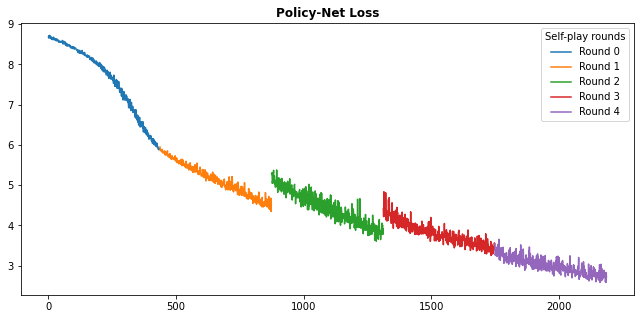

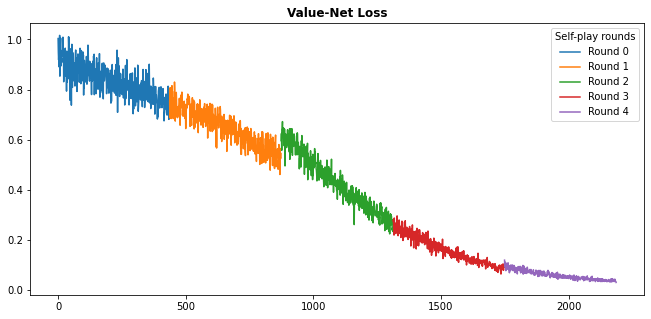

In [5]:
# Plotting loss for both nets across self-play rounds

plt.figure(figsize=(11,5))

for i in range(iterations):
    
    p_loss_fn = parameter_path +  "pnet_loss_v{}.data".format(i)
    
    with open(p_loss_fn, "rb") as f:
        
        data = pickle.load(f)
        
        if i == 0:
            lengths = []
            l = np.empty(0)

        plt.plot(np.arange(len(data))+np.sum(lengths), data, label="Round %s"%i)
        l = np.append(l, np.array(data).reshape(-1,1))
        lengths.append(len(data))
        
plt.legend(title="Self-play rounds")
plt.title("Policy-Net Loss", fontweight="bold"); plt.show()


plt.figure(figsize=(11,5))

for i in range(iterations):
    
    v_loss_fn = parameter_path + "vnet_loss_v{}.data".format(i)
    
    with open(v_loss_fn, "rb") as f:
    
        data = pickle.load(f)
        
        if i == 0:
            lengths = []
            l = np.empty(0)
            
        plt.plot(np.arange(len(data))+np.sum(lengths), data, label="Round %s"%i)
        l = np.append(l, np.array(data).reshape(-1,1))
        lengths.append(len(data))
        
plt.legend(title="Self-play rounds")
plt.title("Value-Net Loss", fontweight="bold"); plt.show()

In [3]:
model = ValueNet()

version = iterations-4
if version > 0: # load parameters from previous versions
    model.load_state_dict(torch.load(parameter_path + "vnet_v{}".format(version)))
print(version)

state = [-1, -1, 0, -1, 1, 0, 0, 0, 1]
print("Guaranteed loss\n", np.array(state).reshape(3,3))
out = model(torch.tensor(state).float())
print("Q =",out.detach().item())

11
Guaranteed loss
 [[-1 -1  0]
 [-1  1  0]
 [ 0  0  1]]
Q = -0.07609741389751434


In [4]:
model = PolicyNet()

version = iterations-1
if version > 0: # load parameters from previous versions
    model.load_state_dict(torch.load(parameter_path + "pnet_v{}".format(version)))
print(version)

14


In [35]:
state = [1, -1, 0, -1, 1, 0, 0, 0, 0]
print(np.array(state).reshape(3,3))
out = model(torch.tensor(state).float())
print(out)
mask = out.detach()[[2,4,5,6,7]]
print("Q =",mask.exp()/mask.exp().sum())

Bad start
 [[ 1 -1  0]
 [-1  1  0]
 [ 0  0  0]]
tensor([-2.4101, -1.5256, -3.6887, -4.6060, -2.7868, -4.4087, -1.4790, -3.3126,
        -1.1406], grad_fn=<LogSoftmaxBackward>)
Q = tensor([0.0689, 0.1697, 0.0335, 0.6276, 0.1003])


[1, 0, 0, 4999, 0]
[[ 0  0  0]
 [-1  1 -1]
 [ 0  1  0]]
pi = [2.000e-04 0.000e+00 0.000e+00 9.998e-01 0.000e+00]
Next Move = 3


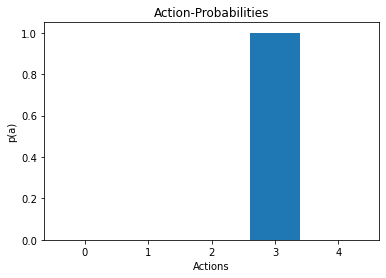

In [9]:
# Have a try with MCTS
state = [0, 0, 0, -1, 1, -1, 0, 1, 0]
mcts = MCTS(state , 1, 5000, parameter_path)
root = mcts.search(version=4)
t = 1 # temperature
visits = [root.child[i].N**t for i in range(len(root.child))]
print(visits)
print(np.array(state).reshape(3,3))
print("pi =", visits/np.sum(visits))
print("Next Move =", np.random.choice(np.arange(len(visits)), p=visits/np.sum(visits), size=1)[0])

plt.bar(np.arange(len(visits)), visits/np.sum(visits))
plt.xlabel("Actions"); plt.ylabel("p(a)"); plt.title("Action-Probabilities");